In [1]:
# Import packages
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
print ("Packages imported")

# Load MNIST, our beloved friend
mnist = input_data.read_data_sets("data/", one_hot=True)
trainimgs, trainlabels, testimgs, testlabels \
 = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels 
ntrain, ntest, dim, nclasses \
 = trainimgs.shape[0], testimgs.shape[0], trainimgs.shape[1], trainlabels.shape[1]
print ("MNIST loaded")

Packages imported
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST loaded


In [2]:
# Recurrent neural network 
nclasses = 10
diminput  = 28
dimhidden = 128
dimoutput = nclasses
nsteps    = 28
weights = {
    'hidden': tf.Variable(tf.random_normal([diminput, dimhidden])), 
    'out': tf.Variable(tf.random_normal([dimhidden, dimoutput]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([dimhidden])),
    'out': tf.Variable(tf.random_normal([dimoutput]))
}
def _RNN(_X, _istate, _W, _b, _nsteps, _name):
    # 1. Permute input from [batchsize, nsteps, diminput] => [nsteps, batchsize, diminput]
    _X = tf.transpose(_X, [1, 0, 2])
    # 2. Reshape input to [nsteps*batchsize, diminput] 
    _X = tf.reshape(_X, [-1, diminput])
    # 3. Input layer => Hidden layer
    _H = tf.matmul(_X, _W['hidden']) + _b['hidden']
    # 4. Splite data to 'nsteps' chunks. An i-th chunck indicates i-th batch data 
    print(tf.shape(_H))
    _Hsplit = tf.split(0, _nsteps, _H)
    print(tf.shape(_Hsplit))
    # 5. Get LSTM's final output (_O) and state (_S)
    #    Both _O and _S consist of 'batchsize' elements
    with tf.variable_scope(_name):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(dimhidden, forget_bias=1.0)
        _LSTM_O, _LSTM_S = tf.nn.rnn(lstm_cell, _Hsplit, initial_state=_istate)
    # 6. Output
    _O = tf.matmul(_LSTM_O[-1], _W['out']) + _b['out']    
    # Return! 
    return {
        'X': _X, 'H': _H, 'Hsplit': _Hsplit,
        'LSTM_O': _LSTM_O, 'LSTM_S': _LSTM_S, 'O': _O 
    }
print ("Network ready")

Network ready


In [3]:
learning_rate = 0.001
x      = tf.placeholder("float", [None, nsteps, diminput])
istate = tf.placeholder("float", [None, 2*dimhidden]) #state & cell => 2x n_hidden
y      = tf.placeholder("float", [None, dimoutput])
myrnn  = _RNN(x, istate, weights, biases, nsteps, 'basic')
pred   = myrnn['O']
cost   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) 
optm   = tf.train.AdamOptimizer(learning_rate).minimize(cost) # Adam Optimizer
accr   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1), tf.argmax(y,1)), tf.float32))
init   = tf.initialize_all_variables()
print ("Network Ready!")

Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape_1:0", shape=(3,), dtype=int32)
Network Ready!


In [4]:
training_epochs = 5
batch_size      = 128
display_step    = 1
sess = tf.Session()
sess.run(init)
summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs', graph=sess.graph)
print ("Start optimization")
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape((batch_size, nsteps, diminput))
        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, istate: np.zeros((batch_size, 2*dimhidden))})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys 
                                              , istate: np.zeros((batch_size, 2*dimhidden))})/total_batch
    # Display logs per epoch step
    if epoch % display_step == 0: 
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys, istate: np.zeros((batch_size, 2*dimhidden))})
        print (" Training accuracy: %.3f" % (train_acc))
        testimgs = testimgs.reshape((ntest, nsteps, diminput))
        test_acc = sess.run(accr, feed_dict={x: testimgs, y: testlabels, istate: np.zeros((ntest, 2*dimhidden))})
        print (" Test accuracy: %.3f" % (test_acc))
print ("Optimization Finished.")

Start optimization
Epoch: 000/005 cost: 0.557652002
 Training accuracy: 0.984
 Test accuracy: 0.892
Epoch: 001/005 cost: 0.152270585
 Training accuracy: 0.953
 Test accuracy: 0.954
Epoch: 002/005 cost: 0.097534198
 Training accuracy: 0.992
 Test accuracy: 0.962
Epoch: 003/005 cost: 0.071666511
 Training accuracy: 0.984
 Test accuracy: 0.967
Epoch: 004/005 cost: 0.056814045
 Training accuracy: 1.000
 Test accuracy: 0.976
Optimization Finished.


In [5]:
print sess.run(myrnn, feed_dict={x: batch_xs, istate: np.zeros((batch_size, 2*dimhidden))})

{'LSTM_O': [array([[ 0.09219566, -0.17965803,  0.1428702 , ..., -0.39806926,
        -0.04826201,  0.06067049],
       [ 0.09219566, -0.17965803,  0.1428702 , ..., -0.39806926,
        -0.04826201,  0.06067049],
       [ 0.09219566, -0.17965803,  0.1428702 , ..., -0.39806926,
        -0.04826201,  0.06067049],
       ..., 
       [ 0.09219566, -0.17965803,  0.1428702 , ..., -0.39806926,
        -0.04826201,  0.06067049],
       [ 0.09219566, -0.17965803,  0.1428702 , ..., -0.39806926,
        -0.04826201,  0.06067049],
       [ 0.09219566, -0.17965803,  0.1428702 , ..., -0.39806926,
        -0.04826201,  0.06067049]], dtype=float32), array([[ 0.16473685, -0.2620835 ,  0.26167488, ..., -0.55289519,
        -0.08563014,  0.05896173],
       [ 0.16473685, -0.2620835 ,  0.26167488, ..., -0.55289519,
        -0.08563014,  0.05896173],
       [ 0.16473685, -0.2620835 ,  0.26167488, ..., -0.55289519,
        -0.08563014,  0.05896173],
       ..., 
       [ 0.16473685, -0.2620835 ,  0.26167488

In [23]:
output = sess.run(myrnn, feed_dict={x: batch_xs, istate: np.zeros((batch_size, 2*dimhidden))})
print output['LSTM_O'][-1].shape
_O = tf.matmul(output['LSTM_O'][-1], weights['out']) +  biases['out'] 
print sess.run(_O).shape

(128, 128)
(128, 10)


In [24]:
list = [1,2,3,4,5,6,7,8]
print list[-1]

8


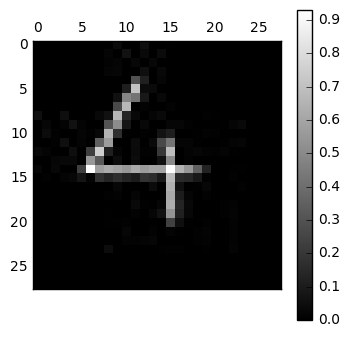

(1, 28, 28)


In [27]:
import os
import matplotlib.pyplot as plt
import PIL
# Load a test handwritten image 
cwd = os.getcwd()
testImage = PIL.Image.open("./sompic.jpg")
imgArray = np.array(testImage)
imgArray = np.asfarray(imgArray, dtype='float32')
imgArray = imgArray - 255
imgArray = imgArray * -1
imgArray = imgArray/255
#imgArray = imgArray + 0.00000000001
plt.matshow(imgArray[:,:], cmap=plt.get_cmap('gray'))
plt.colorbar()
plt.show()
imgArray = np.reshape(imgArray,[1,28,28])
print imgArray.shape

In [29]:

output = sess.run(myrnn, feed_dict={x: imgArray, istate: np.zeros((1, 2*dimhidden))})
print output['LSTM_O'][-1].shape
_O = tf.matmul(output['LSTM_O'][-1], weights['out']) +  biases['out'] 
print sess.run(_O).shape

(1, 128)
(1, 10)


In [30]:
print sess.run(_O)

[[ 0.73396754  1.08033276  1.03859711 -3.935956    4.09501171  1.75968575
   1.01945591  0.43120515 -2.51866293  0.74164414]]


In [ ]:
Again we see 4 